In [1]:
import pandas as pd

## Load data

In [2]:
sales = pd.read_csv('seattle_house_sales.csv')

## Inspect loaded data

In [3]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Draw scatter plot of price vs sqft

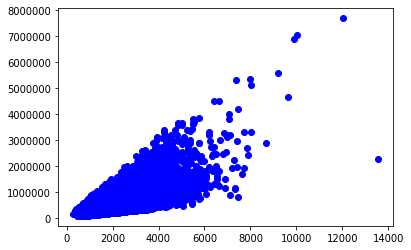

In [4]:
import matplotlib.pyplot as plt
plt.plot(sales['sqft_living'], sales['price'], 'bo')

## Split data into training and test set

In [5]:
import numpy as np
train_data, test_data = np.split(sales.sample(frac=1, random_state=1729), [int(0.8 * len(sales))])
print(train_data.shape, test_data.shape)

(17290, 21) (4323, 21)


## Prepare data

In [6]:
import numpy as np
modelData = np.array(train_data[['sqft_living']].values).astype('float32')
target = np.array(train_data['price']).astype('float32')

## Create s3 bucket

In [7]:
import boto3
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region.")
bucket_name = 'sameer-mahajan'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

Success - the MySageMakerInstance is in the us-east-1 region.
S3 bucket created successfully


### Import necessary libraries

In [8]:
import boto3
import sagemaker
import io
import os
import sagemaker.amazon.common as smac

### Create new sagemaker session

In [9]:
sess = sagemaker.Session() 

### S3 bucket to export results to

In [10]:
bucket = "sameer-mahajan"
prefix = "sameer"

### Use the IO buffer as dataset is small

In [11]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, modelData, target)
buf.seek(0)
key = 'linearregression'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://sameer-mahajan/sameer/train/linearregression
training artifacts will be uploaded to: s3://sameer-mahajan/sameer/output


### Use all regions for ML model

In [12]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest',
              'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/linear-learner:latest'}

In [13]:
from sagemaker import get_execution_role
role = get_execution_role()
linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [14]:
linear.set_hyperparameters(feature_dim=1,
                           predictor_type='regressor',
                           normalize_data=False)

In [15]:
linear.fit({'train': s3_train_data})
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-03 06:46:29 Starting - Starting the training job...
2020-09-03 06:46:31 Starting - Launching requested ML instances......
2020-09-03 06:47:46 Starting - Preparing the instances for training.........
2020-09-03 06:49:29 Downloading - Downloading input data
2020-09-03 06:49:29 Training - Downloading the training image...
2020-09-03 06:49:59 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[09/03/2020 06:49:54 INFO 140245405001536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'au

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 60
Billable seconds: 60
---------------!

### Set up Predictor

In [16]:
from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

### Make a prediction

In [17]:
result = linear_predictor.predict(modelData[0])
print(result)

{'predictions': [{'score': 375153.25}]}


In [18]:
target[0]

199000.0

## Make predictions for test data

In [21]:
testdata = np.array(test_data[['sqft_living']].values).astype('float32')

predictions = []

for data in testdata:
    result = linear_predictor.predict(data)
    predictions += [r['score'] for r in result['predictions']]
    
predictions = np.array(predictions)

### Push predicted prices into our pandas dataframe

In [23]:
test_data['predicted_price'] = predictions.astype(int)

### Compare actual prices and predicted prices of test data

In [25]:
test_data.head()[['id', 'sqft_living', 'price', 'predicted_price']]

,id,sqft_living,price,predicted_price
8805,1687000220,2434,285000,639942
4663,1591600044,3140,409000,842259
2281,5652601455,2300,775000,601542
2992,6381501636,1780,320000,452526
3265,8731902680,1610,218000,403810
